In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import to_tensor, to_pil_image
from albumentations import (HorizontalFlip, Compose, Resize, Normalize)

# Add seeds
np.random.seed(2021)

### Creating training and validation from raw dataset

In [6]:
images_path = '../data/images/'
masks_path = '../data/masks/'

images = [img for img in os.listdir(images_path)]
masks = [mask for mask in os.listdir(masks_path)]

print(f'Number of Images: {len(images)}')
print(f'Number of Masks: {len(masks):>4}')

Number of Images: 743
Number of Masks:  890


The number of masks and images are not equal. So, we will find the respective pairs and discard the rest. After that we will create training and validation dataset.

In [7]:
common_filenames = list(set(images).intersection(masks))
np.random.shuffle(common_filenames)
split_ratio = 0.7
train_set = int(split_ratio*len(common_filenames))
test_set = len(common_filenames) - train_set


train_files = common_filenames[:train_set]
test_files = common_filenames[train_set:]

print(f'Images and Mask in Final Dataset: {len(common_filenames):>4}')
print(f'Train set: {train_set:>27}')
print(f'Test set: {test_set:>28}')

Images and Mask in Final Dataset:  743
Train set:                         520
Test set:                          223


In [12]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
height, width = 520,520

train_transform = Compose([Resize(height, width), 
                          HorizontalFlip(p=0.5),
                          Normalize(mean=mean, std=std)])

test_transform = Compose([Resize(height,width),
                         Normalize(mean=mean, std=std)])

In [78]:
a = Image.open(masks_path+train_files[0])

In [79]:
np.array(a).shape

(800, 840, 3)

In [71]:
class GunsBoxesDataset(Dataset):
    def __init__(self, img_dir, mask_dir, index, transform=None, \
                target_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.index = index
        self.transform = transform
        self.target_transform =target_transform
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.index[idx])
        img = np.array(Image.open(img_path).convert('RGB'))
        mask_path = os.path.join(self.mask_dir, self.index[idx])
        msk = np.array(Image.open(mask_path))
        if self.transform:
            transformed = self.transform(image=img, mask=msk)
            image = transformed['image']
            mask = transformed['mask']
            mask[mask>3] = 0
        image = to_tensor(image)
        mask = torch.from_numpy(mask).type(torch.long)
        return image, mask
    
    def __showImageMask__(self, idx):
        img_path = os.path.join(self.img_dir, self.index[idx])
        image = Image.open(img_path)
        mask_path = os.path.join(self.mask_dir, self.index[idx])
        mask = Image.open(mask_path)
        plt.figure()
        plt.subplot(1,2,1)
        plt.axis('off')
        plt.title('Image')
        plt.imshow(image)
        plt.figure()
        plt.subplot(1,2,2)
        plt.axis('off')
        plt.title('Mask')
        plt.imshow(mask)
        
def ReNormalize(x, mean=mean, std=std):
    x_copy = x.clone()
    for i, (mean_i, std_i) in enumerate(zip(mean, std)):
        x_copy[i] *= std_i
        x_copy[i] += mean_i
    return x_copy

In [72]:
train_dataset = GunsBoxesDataset(img_dir= images_path,
                                mask_dir= masks_path,
                                index= train_files,
                                transform=train_transform)

test_dataset = GunsBoxesDataset(img_dir= images_path,
                                mask_dir= masks_path,
                                index= test_files,
                                transform=test_transform)

In [73]:
img, msk = train_dataset[500]
print(img.shape, img.type(), torch.max(img))
print(msk.shape, msk.type(), torch.max(msk))

torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.3936)
torch.Size([520, 520, 3]) torch.LongTensor tensor(0)


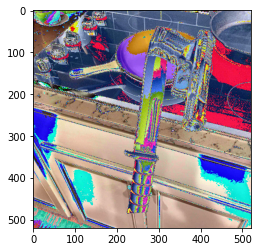

In [74]:
plt.imshow(to_pil_image(img))

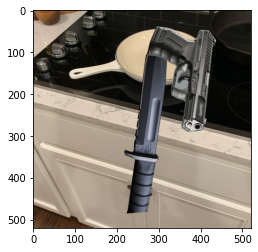

In [75]:
plt.imshow(to_pil_image(ReNormalize(img)))

In [76]:
plt.imshow(to_pil_image(msk))

ValueError: pic should not have > 4 channels. Got 520 channels.